# IMPORTING DEPENDENCIES

In [1]:
import tensorflow
import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation,Dropout,SpatialDropout1D,Bidirectional,LSTM
from tensorflow.keras.layers import Conv1D,MaxPooling1D,GlobalAveragePooling1D,GlobalMaxPooling1D

import pandas as pd
import numpy as np
import gensim
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ARCHITECTURE

1. Importing Dataset and encoding the label 
2. Preprocessing the text by removing stop words,punctuations,html tags,hash tags,numbers,emoticons,case folding and lemmatization
3. Tokenizing using Keras Tokenizer 
4. Converting text data to sequences of integers and padding
5. Building Keras LSTM Model
6. Plotting the Accuracies and Losses

# Importing Dataset and encoding the label

##Dataset :
https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [3]:
df = pd.read_csv("/content/drive/MyDrive/imdb.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Here there are about 50000 rows and 2 columns

Sentiment Column has labels as : positive and negative

We have to encode the labels as :   positive as 1  and negative as 0


In [4]:
mapping = dict(positive=1,
               negative=0)

# creating a mapping to encode the labels
df['sentiment'] = df['sentiment'].map(mapping)

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [5]:
# Finding the value counts for each label
df.sentiment.value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [6]:
# checking out if there is any null values in the dataset
df.isna().sum()

# no null values seems to be found

review       0
sentiment    0
dtype: int64

In [7]:
# text = df['review'].tolist()
# # text

In [8]:
# converting the sentiment column of the dataframe to numpy array
label = df['sentiment']
label = label.to_numpy()
type(label)

numpy.ndarray

In [9]:
# downloading nltk dependencies
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [10]:
all_stopwords = stopwords.words('english')
negation = ['no','not']
all_stopwords = [w for w in all_stopwords if w not in negation]

def preprocessing(data):
    corpus = []
    for i in range(len(data)):
        # remove urls
        tweet = re.sub(r'http\S+', ' ', data[i]) # links

        # remove html tags
        tweet = re.sub(r'<.*?>', ' ', tweet) # tags        
        tweet = re.sub('&\w+([-.]\w+)*', ' ', tweet) # colorcodes

        # remove digits
        tweet = re.sub(r'\d+', ' ', tweet)
        tweet = re.sub('@\w+([-.]\w+)*', ' ', tweet) # mentions

        # remove emojis
        emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
        tweet = emoji_pattern.sub(r'', tweet) # no emoji

        # remove hashtags
        tweet = re.sub(r'#\w+', ' ', tweet) # hashtags
        review = re.sub('[^a-zA-Z]', ' ', tweet) # any characters other than alphabets
        review = review.lower() # casefolding
        review = review.split() 
        lemma= WordNetLemmatizer() # lemmatization
        review = [lemma.lemmatize(word) for word in review if word not in all_stopwords]
        review = ' '.join(review)
        corpus.append(review)
    return corpus

In [11]:
review = preprocessing(df['review'])

# embedding

In [12]:
X_train, X_test,y_train,y_test = train_test_split(review,label,test_size=0.20,stratify = label,random_state=42)

In [13]:
token = Tokenizer(lower=True)
token.fit_on_texts(X_train)

In [14]:
# Convert text data to sequences of integers
train_sequences = token.texts_to_sequences(X_train)
valid_sequences = token.texts_to_sequences(X_test)

In [15]:
vocab_size = len(token.word_index)+1
vocab_size

# there are 89657 unique words in the corpus 
# we will feed this to the input_dim of embedding layer
# +1 because the index starts from 0

81371

In [16]:
maxlen = 100

train_data = pad_sequences(train_sequences, maxlen=maxlen,padding = 'post')
valid_data = pad_sequences(valid_sequences, maxlen=maxlen,padding = 'post')


In [17]:
train_data.shape

(40000, 100)

In [18]:
# X is a Sequence of Token Indexes not the actual  vector that  represents the sentences
# The word Vector will always will be in the range of -1 and +1 and that will be projected inside ML model automatically to train the model

# our next task is to convert the sequence of token indices to vector representation 

# Building Convolutional Neural Network Model

In [19]:
vec_size = 200


model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = vec_size,input_length=maxlen,trainable=False))

model.add(Conv1D(64,8,activation = 'relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32,activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(16,activation = 'relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1,activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          16274200  
                                                                 
 conv1d (Conv1D)             (None, 93, 64)            102464    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 46, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 46, 64)            0         
                                                                 
 dense (Dense)               (None, 46, 32)            2080      
                                                                 
 dropout_1 (Dropout)         (None, 46, 32)            0         
                                                        

In [20]:
model.compile(optimizer = 'adam',loss = 'binary_crossentropy' ,metrics = ['accuracy'])

In [21]:
history = model.fit(train_data,y_train,epochs=5,validation_data=(valid_data,y_test))

Epoch 1/5
1250/1250 [==============================] - 18s 5ms/step - loss: 0.6389 - accuracy: 0.6191 - val_loss: 0.6244 - val_accuracy: 0.6231
Epoch 2/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.5536 - accuracy: 0.7153 - val_loss: 0.5937 - val_accuracy: 0.6535
Epoch 3/5
1250/1250 [==============================] - 8s 6ms/step - loss: 0.5058 - accuracy: 0.7487 - val_loss: 0.5760 - val_accuracy: 0.6703
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.4655 - accuracy: 0.7782 - val_loss: 0.5929 - val_accuracy: 0.6311
Epoch 5/5
1250/1250 [==============================] - 8s 6ms/step - loss: 0.4331 - accuracy: 0.7991 - val_loss: 0.5599 - val_accuracy: 0.6872


In [ ]:
import pickle
with open ("cnn_sentiment_analysis.pkl",'wb') as f:
    pickle.dump(model,f)

In [23]:
score = model.evaluate(valid_data,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.5599 - accuracy: 0.6872


In [24]:
print("Test score :",score[0])
print("Test Accuracy :",score[1])

Test score : 0.559927225112915
Test Accuracy : 0.6872000098228455


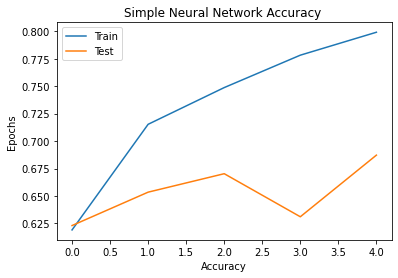

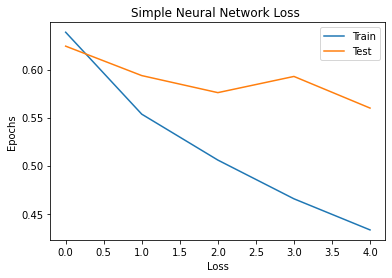

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Simple Neural Network Accuracy ")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.legend(['Train','Test'],loc='best')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Simple Neural Network Loss ")
plt.xlabel("Loss")
plt.ylabel("Epochs")
plt.legend(['Train','Test'],loc='best')
plt.show()



#  Building  LSTM  Model

In [26]:
from keras.layers import LSTM

In [27]:
vec_size = 200
lstm =Sequential()
# Embedding layer
lstm.add(Embedding(input_dim = vocab_size, output_dim = vec_size,input_length=maxlen,trainable = False))
#lstm
lstm.add(LSTM(100,dropout=0.20))
lstm.add(Dense(1,activation='sigmoid'))

In [28]:
lstm.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
print(lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 200)          16274200  
                                                                 
 lstm (LSTM)                 (None, 100)               120400    
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 16,394,701
Trainable params: 120,501
Non-trainable params: 16,274,200
_________________________________________________________________
None


In [29]:
lstm_history = lstm.fit(train_data,y_train,epochs=15,validation_data=(valid_data,y_test))

Epoch 1/15
1250/1250 [==============================] - 12s 8ms/step - loss: 0.6917 - accuracy: 0.5177 - val_loss: 0.6896 - val_accuracy: 0.5067
Epoch 2/15
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6897 - accuracy: 0.5331 - val_loss: 0.6863 - val_accuracy: 0.5613
Epoch 3/15
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6735 - accuracy: 0.5681 - val_loss: 0.7137 - val_accuracy: 0.5731
Epoch 4/15
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6768 - accuracy: 0.5635 - val_loss: 0.6825 - val_accuracy: 0.5434
Epoch 5/15
1250/1250 [==============================] - 8s 7ms/step - loss: 0.6802 - accuracy: 0.5590 - val_loss: 0.6900 - val_accuracy: 0.5144
Epoch 6/15
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6821 - accuracy: 0.5560 - val_loss: 0.6847 - val_accuracy: 0.5516
Epoch 7/15
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6854 - accuracy: 0.5470 - val_loss: 0.6821 - val_accuracy

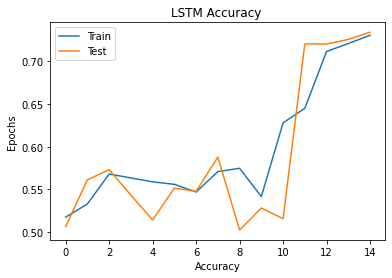

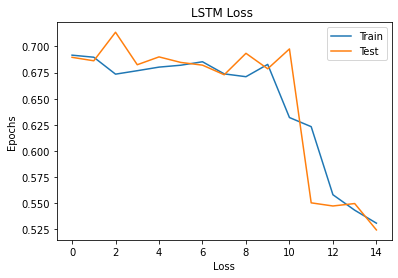

In [30]:
import matplotlib.pyplot as plt
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title("LSTM Accuracy ")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.legend(['Train','Test'],loc='best')
plt.show()


plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title("LSTM Loss ")
plt.xlabel("Loss")
plt.ylabel("Epochs")
plt.legend(['Train','Test'],loc='best')
plt.show()



In [ ]:
import pickle
with open ("lstm_sentiment_analysis.pkl",'wb') as f:
    pickle.dump(lstm,f)